In [1]:
from apps.generalizedshallowwater import generalized_shallow_water
from apps.generalizedshallowwater.torrilhonexample import torrilhon_example
from pydogpack import main
from pydogpack.tests.utils import utils
from pydogpack.utils import dg_utils
from pydogpack.utils import math_utils
from pydogpack.utils import x_functions
from pydogpack.visualize import plot

from IPython.display import HTML
from copy import deepcopy

# Torrilhon Example

In [2]:
num_moments = 0

gravity_constant = 1.0
kinematic_viscosity = 0.0
slip_length = 0.0

displacement = 0.5
velocity = 0.25
linear_coefficient = 0.25
quadratic_coefficient = 0.0
cubic_coefficient = 0.0

max_height = 1.4

problem = torrilhon_example.TorrilhonExample(
    num_moments,
    gravity_constant,
    kinematic_viscosity,
    slip_length,
    displacement,
    velocity,
    linear_coefficient,
    quadratic_coefficient,
    cubic_coefficient,
    max_height,
)

time_final = 2.0
problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True

space_time_order = 1
problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["num_frames"] = 30
problem.parameters["time_stepping"]["order"] = space_time_order

num_elems = 300
x_left = -1.0
x_right = 1.0
problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"
problem.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

#cfl = dg_utils.standard_cfls(space_time_order)
cfl = 0.5
problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))

main.setup_objects(problem);

In [3]:
final_solution = main.run(problem);

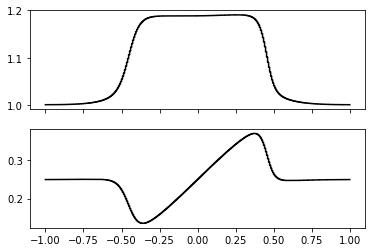

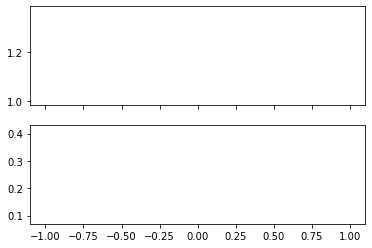

In [4]:
p = plot.create_plot_dg(final_solution, transformation=generalized_shallow_water.get_primitive_variables)
ani, fig = plot.create_animation_output_dir(problem.output_dir, transformation=generalized_shallow_water.get_primitive_variables)
HTML(ani.to_html5_video())

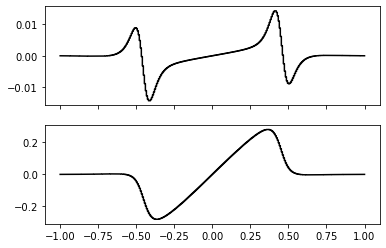

In [68]:
mesh_ = final_solution.mesh_
num_elems = mesh_.num_elems
def sym_func(x, elem_index):
    return final_solution(x, elem_index) - final_solution(-x, num_elems - 1 - elem_index)
test_sol = final_solution.basis_.project(sym_func, mesh_, 5, None, True)
p = test_sol.create_plot()

# Testing

In [55]:
num_moments = 1
gravity_constant = 1.0
kinematic_viscosity = 0.0
slip_length = 0.0

displacement = 0.5
velocity = 0.25
linear_coefficient = 0.25
quadratic_coefficient = 0.0
cubic_coefficient = 0.0

max_height = 1.4

time_final = 2.0
space_time_order = 1

num_elems = 400
x_left = -1.0
x_right = 1.0

problem = torrilhon_example.TorrilhonExample(
    num_moments,
    gravity_constant,
    kinematic_viscosity,
    slip_length,
    displacement,
    velocity,
    linear_coefficient,
    quadratic_coefficient,
    cubic_coefficient,
    max_height,
)

problem.parameters["time_final"] = time_final
problem.parameters["is_weak"] = True
problem.parameters["use_wave_propogation_method"] = False

problem.parameters["time_stepping"]["time_stepping_class"] = "explicit_runge_kutta"
problem.parameters["time_stepping"]["is_verbose"] = False
problem.parameters["time_stepping"]["num_frames"] = 30
problem.parameters["time_stepping"]["order"] = space_time_order


problem.parameters["mesh"]["mesh_class"] = "mesh_1d_uniform"
problem.parameters["mesh"]["x_left"] = x_left
problem.parameters["mesh"]["x_right"] = x_right
problem.parameters["mesh"]["num_elems"] = num_elems

problem.parameters["basis"]["basis_class"] = "legendre"
problem.parameters["basis"]["inner_product_constant"] = 0.5
problem.parameters["basis"]["num_basis_cpts"] = space_time_order

problem.parameters["boundary_condition"]["boundary_condition_class"] = "periodic"

#cfl = dg_utils.standard_cfls(space_time_order)
cfl = 0.5
problem.parameters["delta_t"] = float(dg_utils.get_delta_t(cfl, problem.max_wavespeed, (x_right - x_left) / num_elems))

## Discontinuous Galerkin Test with Local Lax Friedrichs Riemann Solver

### Wrong wave speeds in linear coefficient

In [56]:
problem_dg_llf = deepcopy(problem)
problem_dg_llf.parameters["riemann_solver"]["riemann_solver_class"] = "local_lax_friedrichs"

In [57]:
final_solution_dg_llf = main.run(problem_dg_llf)

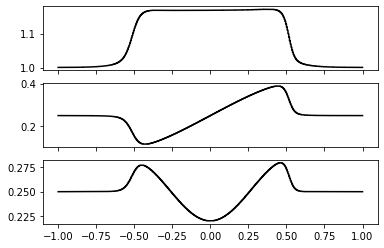

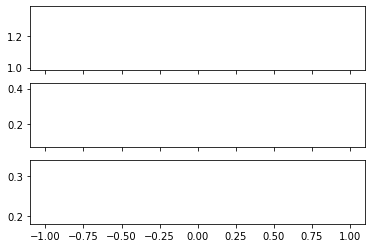

In [58]:
p = plot.create_plot_dg(final_solution_dg_llf, transformation=generalized_shallow_water.get_primitive_variables)
ani, fig = plot.create_animation_output_dir(problem_dg_llf.output_dir, transformation=generalized_shallow_water.get_primitive_variables)
HTML(ani.to_html5_video())

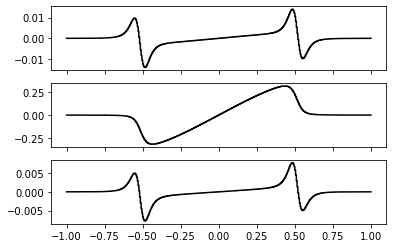

In [59]:
mesh_ = final_solution_dg_llf.mesh_
num_elems = mesh_.num_elems
def sym_func(x, elem_index):
    return final_solution_dg_llf(x, elem_index) - final_solution_dg_llf(-x, num_elems - 1 - elem_index)
test_sol = final_solution_dg_llf.basis_.project(sym_func, mesh_, 5, None, True)
p = test_sol.create_plot()

## Finite Volume Test

In [60]:
problem_fv = deepcopy(problem)
problem_fv.output_dir = "output_finite_volume_reference"
problem_fv.parameters["use_wave_propogation_method"] = True
problem_fv.parameters["fluctuation_solver"]["fluctuation_solver_class"] = "roe"

In [61]:
final_solution_fv = main.run(problem_fv);

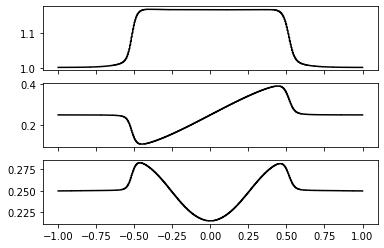

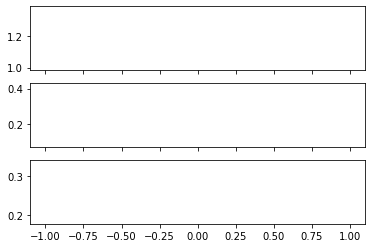

In [62]:
p = plot.create_plot_dg(final_solution_fv, transformation=generalized_shallow_water.get_primitive_variables)
ani, fig = plot.create_animation_output_dir(problem_fv.output_dir, transformation=generalized_shallow_water.get_primitive_variables)
HTML(ani.to_html5_video())

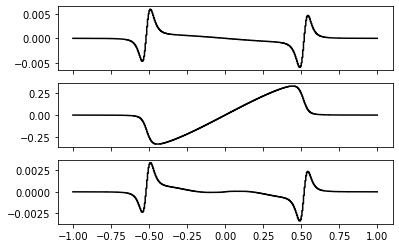

In [63]:
mesh_ = final_solution_fv.mesh_
num_elems = mesh_.num_elems
def sym_func(x, elem_index):
    return final_solution_fv(x, elem_index) - final_solution_fv(-x, num_elems - 1 - elem_index)
test_sol = final_solution_fv.basis_.project(sym_func, mesh_, 5, None, True)
p = test_sol.create_plot()

## Discontinuous Galerkin Test with Nonconservative Riemann Solver

In [64]:
problem_dg_nc = deepcopy(problem)
problem_dg_nc.parameters["riemann_solver"]["riemann_solver_class"] = "nonconservative_hlle"

In [65]:
final_solution_dg_nc = main.run(problem_dg_nc);

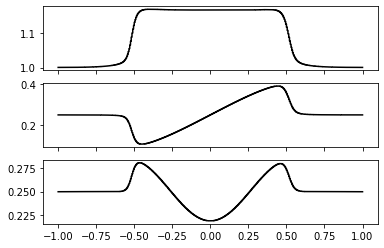

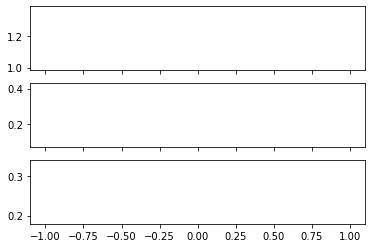

In [66]:
p = plot.create_plot_dg(final_solution_dg_nc, transformation=generalized_shallow_water.get_primitive_variables)
ani, fig = plot.create_animation_output_dir(problem_dg_nc.output_dir, transformation=generalized_shallow_water.get_primitive_variables)
HTML(ani.to_html5_video())

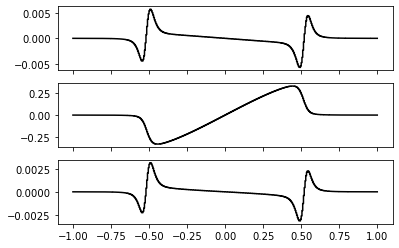

In [67]:
mesh_ = final_solution_dg_nc.mesh_
num_elems = mesh_.num_elems
def sym_func(x, elem_index):
    return final_solution_dg_nc(x, elem_index) - final_solution_dg_nc(-x, num_elems - 1 - elem_index)
test_sol = final_solution_dg_nc.basis_.project(sym_func, mesh_, 5, None, True)
p = test_sol.create_plot()

## Debugging

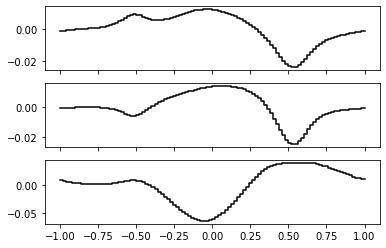

In [23]:
(final_solution_fv - final_solution_dg_nc).create_plot();

In [6]:
(final_solution_dg_nc - final_solution_dg_llf).create_plot();

NameError: name 'final_solution_dg_llf' is not defined

In [10]:
main.setup_objects(problem_fv)
main.setup_objects(problem_dg_llf)
main.setup_objects(problem_dg_nc)
rhs_function_fv = problem_fv.app_.get_explicit_operator_fv(problem_fv.fluctuation_solver, problem_fv.boundary_condition)
rhs_function_dg_llf = problem_dg_llf.app_.get_explicit_operator(problem_dg_llf.riemann_solver, problem_dg_llf.boundary_condition)
rhs_function_dg_nc = problem_dg_nc.app_.get_explicit_operator(problem_dg_nc.riemann_solver, problem_dg_llf.boundary_condition)
rhs_fv = rhs_function_fv(0.0, problem_fv.dg_solution)
rhs_dg_llf = rhs_function_dg_llf(0.0, problem_dg_llf.dg_solution)
rhs_dg_nc = rhs_function_dg_nc(0.0, problem_dg_nc.dg_solution)

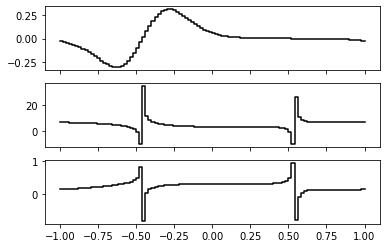

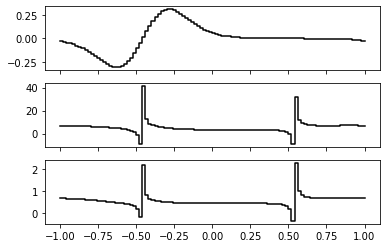

In [11]:
rhs_fv.create_plot(transformation=generalized_shallow_water.get_primitive_variables);
rhs_dg_nc.create_plot(transformation=generalized_shallow_water.get_primitive_variables);

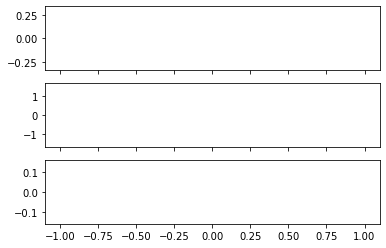

In [14]:
ani, fig = plot.create_animation_dg([rhs_fv, rhs_dg_nc])
HTML(ani.to_html5_video())

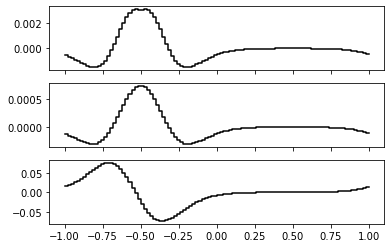

In [13]:
(rhs_fv - rhs_dg_nc).create_plot();

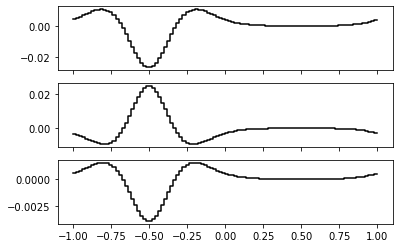

In [28]:
(rhs_dg_llf - rhs_dg_nc).create_plot();